**SERVICIO EDUCACIONAL HOGAR Y SALUD DEL NORTE**

**INDICADOR: Cantidad distribuida anual promedio por categoría**


Christian Ovalle

In [ ]:
!pip install catboost
!pip install scikit-learn==1.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 76.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


**1. PREPARACIÓN DE LA DATA**

  En esta sección se preparan los datos necesarios para aplicar el modelo. Se realiza la instalación de bibliotecas, la lectura del archivo Excel, la transformación de los datos, la aplicación de técnicas pertinentes de preprocesamiento de datos y la separación de los datos en conjuntos de entrenamiento y prueba.

['Biblias' 'Denominacional' 'Educases' 'Himnario' 'Libros de actividades'
 'Ministerio Joven' 'Tarjetas y marcadores' 'Titulos varios']


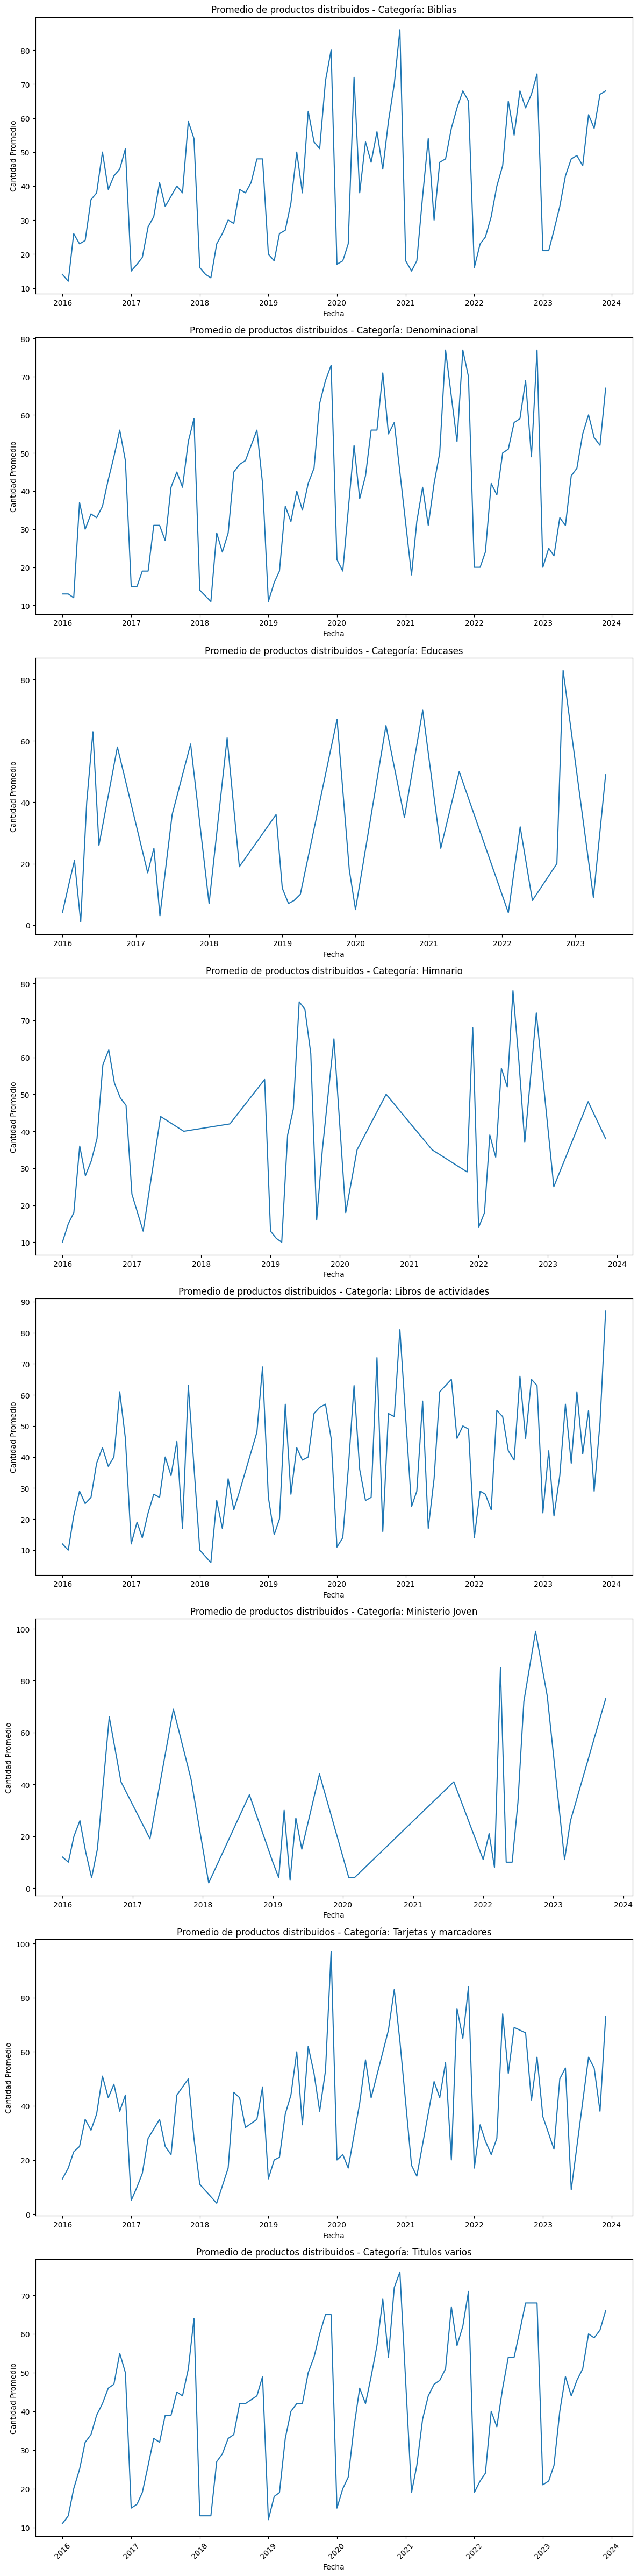

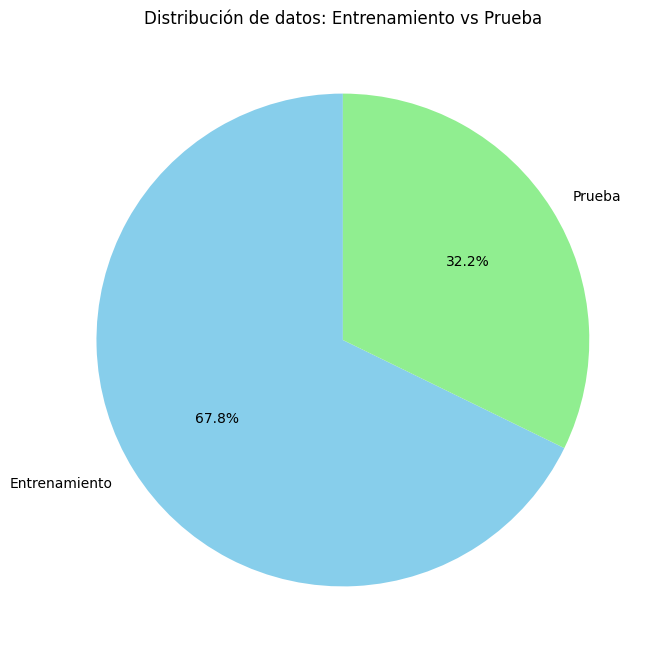

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsRegressor

# Cargar el dataset
file_path = "/content/Datasets_Base_familias.xlsx"
dataset = pd.read_excel(file_path)

# Preparación de los Datos
data = pd.DataFrame()
data['categoria'] = dataset['Categoria']
data['cantidad'] = dataset['Cantidad']
data['fecha'] = dataset['fecha'].dt.to_period('M')

# Agrupar las ventas por categoría y año, calculando el promedio de cantidad
df_promedio_categoria = data.groupby(['categoria', 'fecha'])['cantidad'].mean().reset_index()

# Redondear los valores de la columna 'cantidad'
df_promedio_categoria['cantidad'] = df_promedio_categoria['cantidad'].round()
df_promedio_categoria['fecha'] = pd.to_datetime(df_promedio_categoria['fecha'].astype(str), format='%Y-%m')

# Manejo de valores atípicos
z_scores = zscore(df_promedio_categoria['cantidad'])
df_promedio_categoria = df_promedio_categoria[(np.abs(z_scores) < 3)]



# Convertir las categorías a variables dummy
df_encoded = pd.get_dummies(df_promedio_categoria, columns=['categoria'])
df_encoded['Year'] = df_encoded['fecha'].dt.year
df_encoded['Month'] = df_encoded['fecha'].dt.month

# Filtrar los datos para el entrenamiento y validación
df_train = df_encoded[df_encoded['Year'] < 2024]
df_test = df_encoded[df_encoded['Year'] >= 2020]

# Definir características (X) y objetivo (y)
X_train = df_train.drop(columns=['cantidad', 'fecha'])
y_train = df_train['cantidad']

# Definir X_test con las mismas columnas que X
X_test = df_test[X_train.columns]
y_test = df_test['cantidad']


# Escalamiento de las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lista única de categorías
categorias = df_promedio_categoria['categoria'].unique()
print(categorias)

# Crear un gráfica de la cantidad promedio al paso del tiempo por cada categoría
fig, axes = plt.subplots(nrows=len(categorias), figsize=(12, 6 * len(categorias)))

for i, categoria in enumerate(categorias):
    # Filtrar los datos para la categoría actual
    datos_categoria = df_promedio_categoria[df_promedio_categoria['categoria'] == categoria]

    # Crear gráfica de línea en el subplot correspondiente
    sns.lineplot(data=datos_categoria, x='fecha', y='cantidad', ax=axes[i])

    # Configurar título, etiquetas, y estilo
    axes[i].set_title(f'Promedio de productos distribuidos - Categoría: {categoria}')
    axes[i].set_xlabel('Fecha')
    axes[i].set_ylabel('Cantidad Promedio')

# Ajustar el diseño
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Visualización de la división de datos
division_labels = ['Entrenamiento', 'Prueba']
division_sizes = [len(X_train), len(X_test)]

plt.figure(figsize=(8, 8))
plt.pie(division_sizes, labels=division_labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
plt.title('Distribución de datos: Entrenamiento vs Prueba')
plt.show()

**2. SELECCIÓN DE LOS MODELOS**

Se definen los modelos base que participarán en el conjunto (Stacking), como KNN, GradientBoosting y CatBoost, junto con el meta-modelo, que combina las predicciones de los modelos base. Esta selección se realiza en función de sus capacidades para manejar datos tabulares y ofrecer un buen equilibrio entre
rendimiento y flexibilidad.

In [ ]:
# 2. SELECCIÓN DEL MODELO
def build_stacking_model():
    estimators = [
        ('knn', KNeighborsRegressor()),
        ('gb', GradientBoostingRegressor()),
        ('catboost', CatBoostRegressor(verbose=0, random_seed=42, loss_function='RMSE'))
    ]
    return StackingRegressor(
        estimators=estimators,
        final_estimator=LinearRegression(),
        cv=10
    )

**3. ENTRENAMIENTO DEL MODELO**

Se entrena cada modelo base utilizando los datos de entrenamiento procesados. Cada modelo aprende patrones en los datos de forma independiente, generando predicciones que más tarde se combinarán para formar el modelo de Stacking.

In [ ]:
# 3. ENTRENAMIENTO DE LOS MODELOS BASE
stacking_model = build_stacking_model()
stacking_model.fit(X_train_scaled, y_train)

StackingRegressor(cv=10,
                  estimators=[('knn', KNeighborsRegressor()),
                              ('gb', GradientBoostingRegressor()),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x78f0b5359930>)],
                  final_estimator=LinearRegression())


**4. OPTIMIZACIÓN DE LOS HIPERPARÁMETROS**

En esta etapa, se optimizan los parámetros de los modelos base utilizando RandomizedSearchCV, lo que permite encontrar combinaciones de hiperparámetros que maximizan el desempeño del modelo. Al final, se seleccionan e imprimen los mejores hiperparámetros para cada modelo base, mejorando la precisión del conjunto.

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros encontrados:
{'knn__p': 1, 'knn__n_neighbors': 7, 'gb__n_estimators': 150, 'gb__min_samples_split': 5, 'gb__max_depth': 5, 'gb__learning_rate': 0.01, 'catboost__learning_rate': 0.01, 'catboost__iterations': 500, 'catboost__depth': 5}


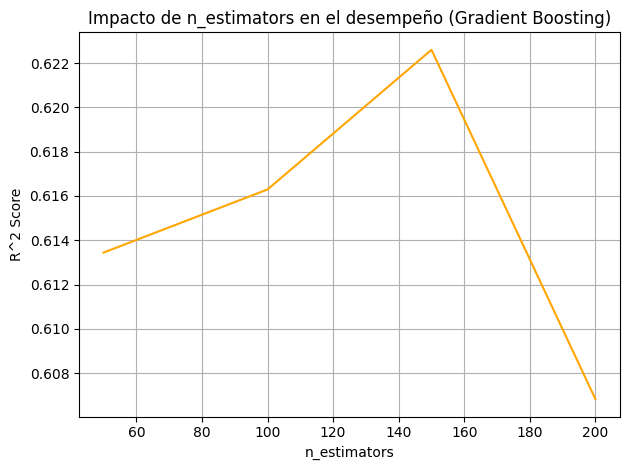

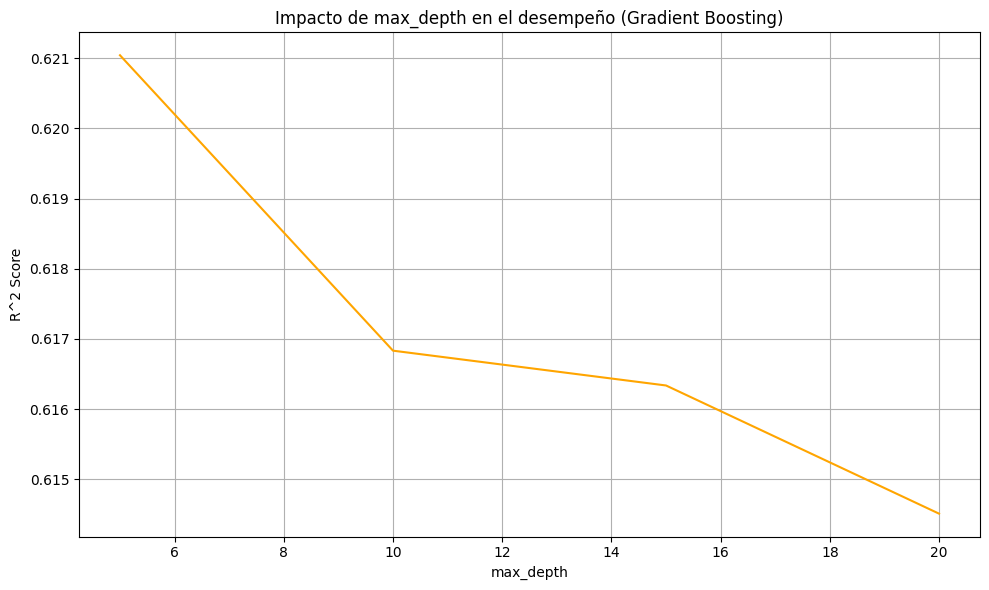

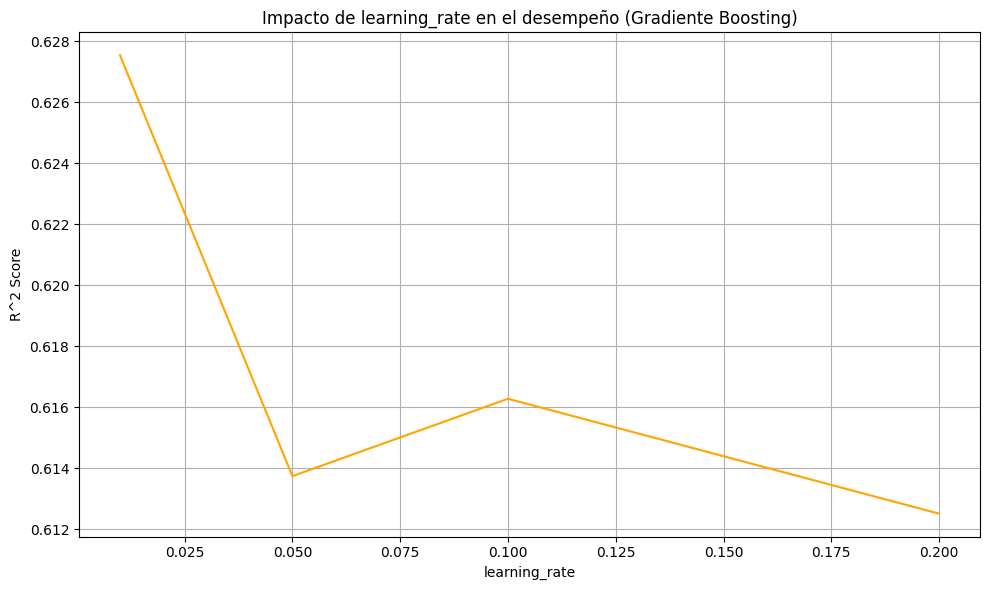

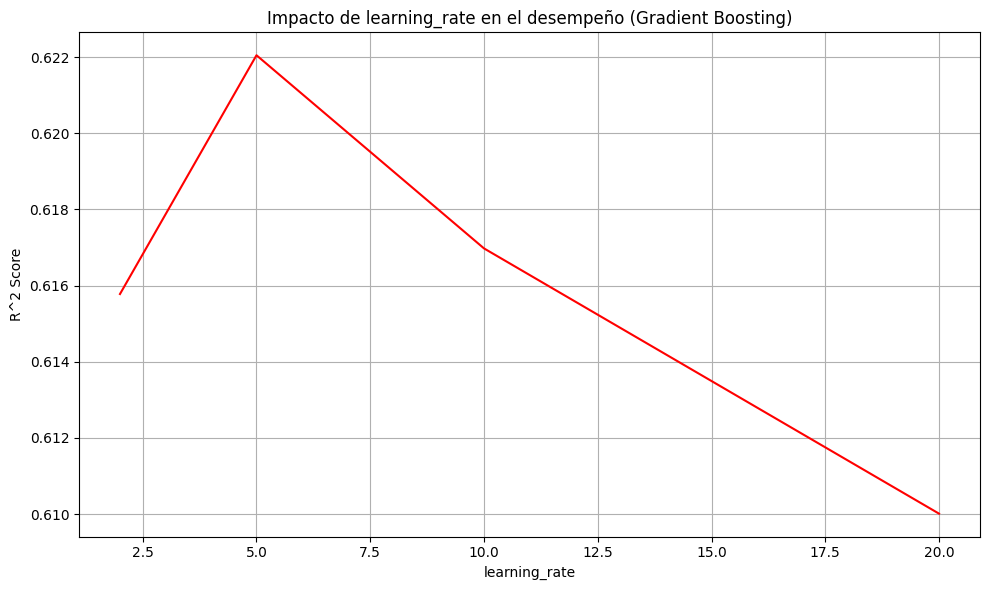

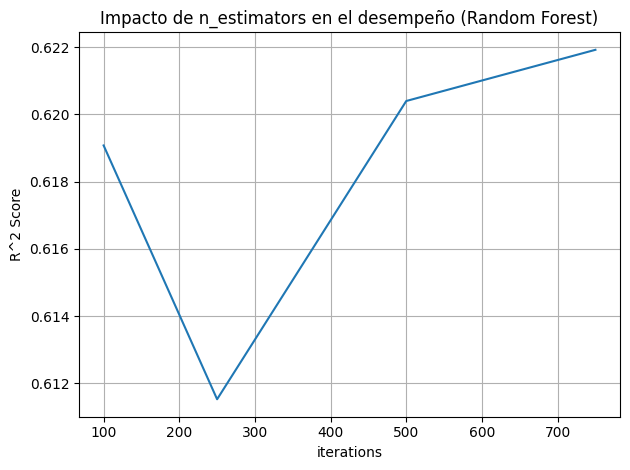

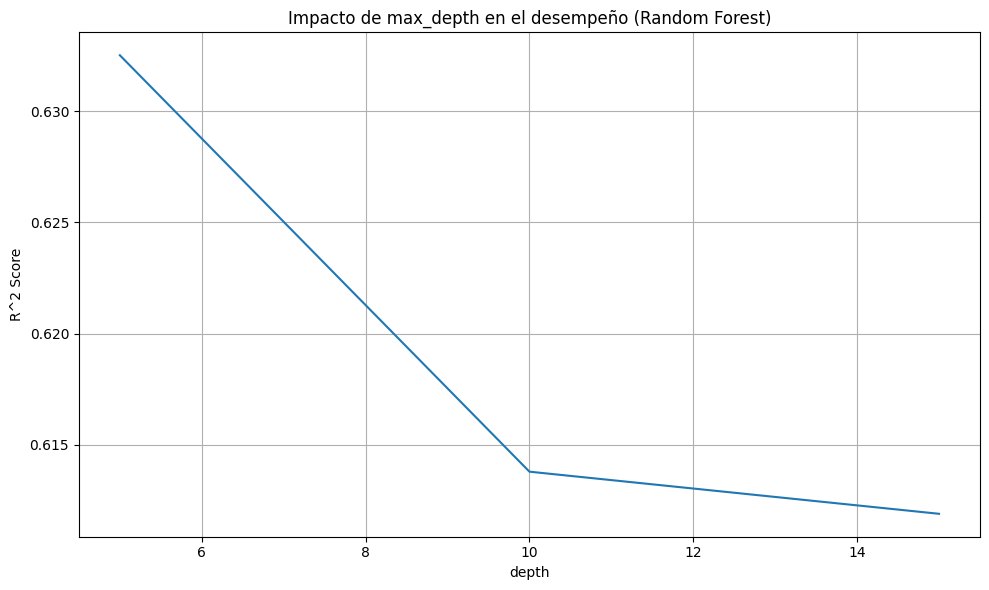

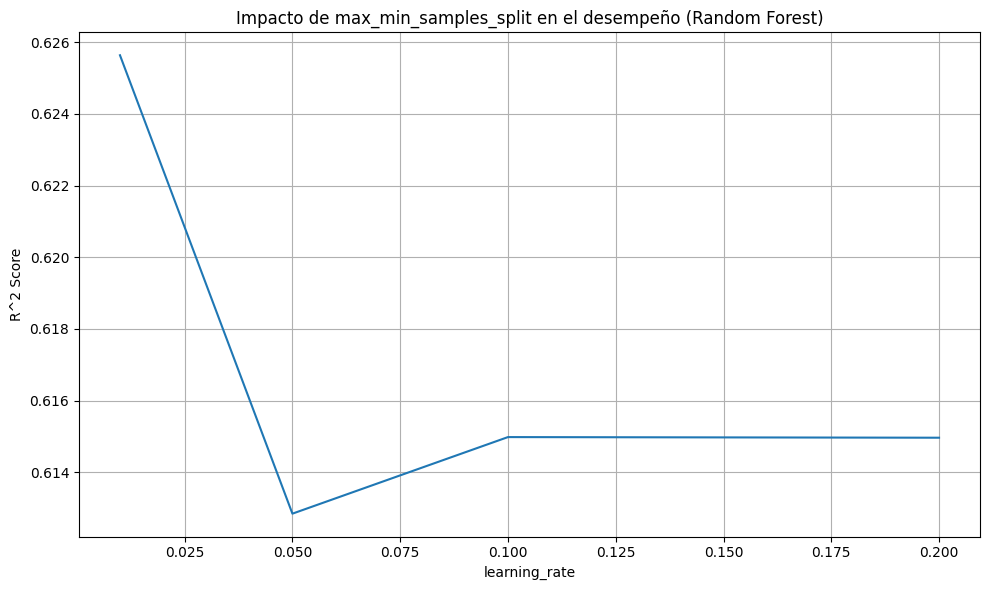

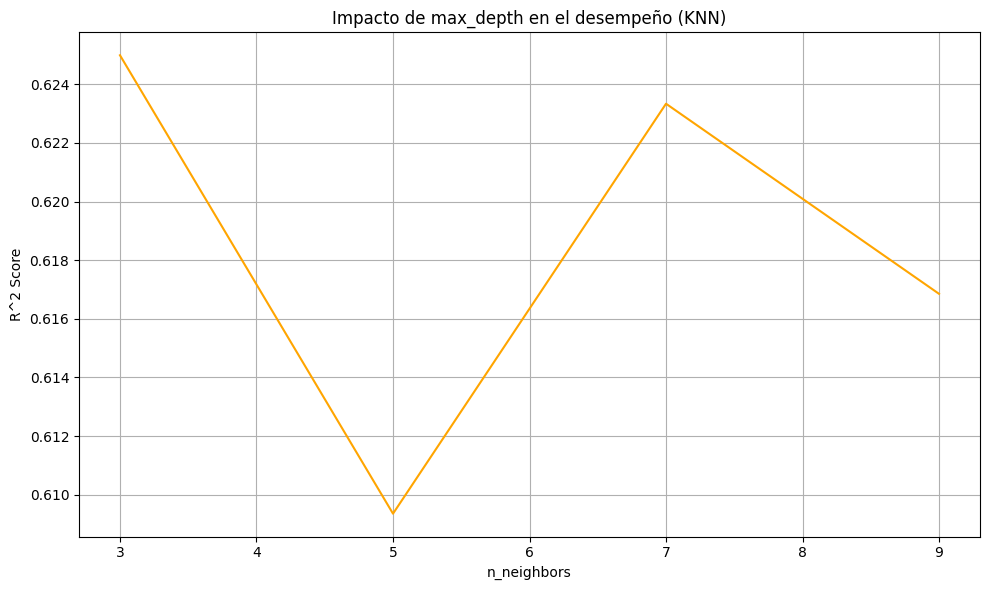

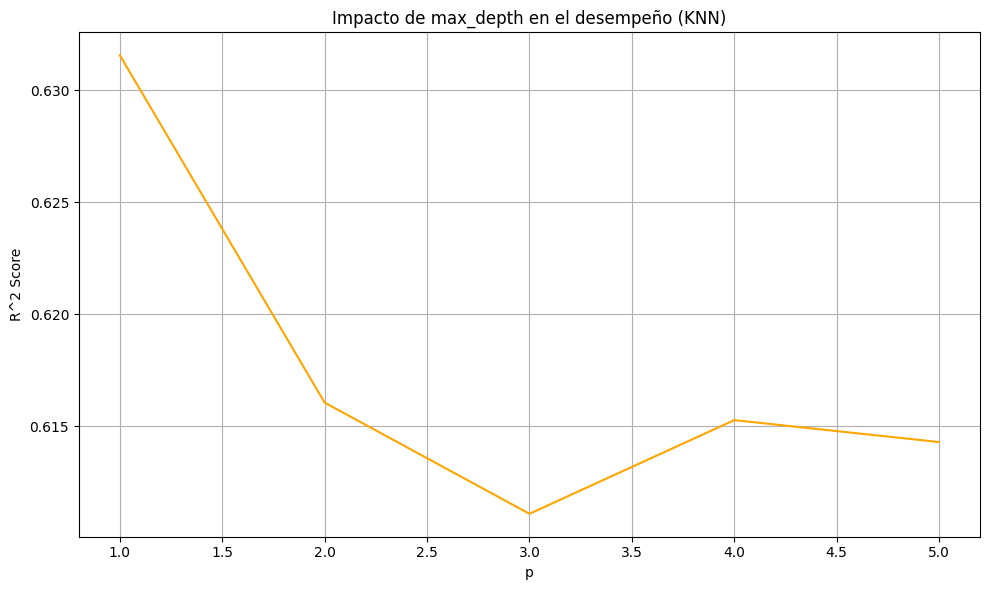

In [ ]:
# 4. OPTIMIZACIÓN DE LOS HIPERPARÁMETROS
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__p': [1, 2, 3, 4, 5],
    "gb__n_estimators": [50, 100, 150, 200],
    "gb__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "gb__max_depth": [5, 10, 15, 20],
    "gb__min_samples_split": [2, 5, 10,20],
    'catboost__iterations': [100, 250, 500, 750],
    'catboost__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'catboost__depth': [5, 10, 15, 20]
}
random_search = RandomizedSearchCV(
    estimator=build_stacking_model(),
    param_distributions=param_grid,
    scoring='r2',
    n_iter=20,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train_scaled, y_train)
best_model = random_search.best_estimator_

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Resultados del ajuste de hiperparámetros
results = pd.DataFrame(random_search.cv_results_)

#Para GradientBoosting
xgb_results = results[["param_gb__n_estimators", "param_gb__learning_rate", "param_gb__max_depth", "param_gb__min_samples_split", "mean_test_score"]]

sns.lineplot(x="param_gb__n_estimators", y="mean_test_score", data=xgb_results, errorbar=None, color='orange')
plt.title("Impacto de n_estimators en el desempeño (Gradient Boosting)")
plt.xlabel("n_estimators")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_gb__max_depth", y="mean_test_score", data=xgb_results, errorbar= None, color='orange')
plt.title("Impacto de max_depth en el desempeño (Gradient Boosting)")
plt.xlabel("max_depth")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_gb__learning_rate", y="mean_test_score", data=xgb_results, errorbar= None,color='orange')
plt.title("Impacto de learning_rate en el desempeño (Gradiente Boosting)")
plt.xlabel("learning_rate")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_gb__min_samples_split", y="mean_test_score", data=xgb_results, errorbar= None,color='red')
plt.title("Impacto de learning_rate en el desempeño (Gradient Boosting)")
plt.xlabel("learning_rate")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

# Para Catboost
catboost_results = results[["param_catboost__iterations", "param_catboost__depth", "param_catboost__learning_rate", "mean_test_score"]]

sns.lineplot(x="param_catboost__iterations", y="mean_test_score", data=catboost_results, errorbar= None)
plt.title("Impacto de n_estimators en el desempeño (Random Forest)")
plt.xlabel("iterations")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_catboost__depth", y="mean_test_score", data=catboost_results, errorbar= None)
plt.title("Impacto de max_depth en el desempeño (Random Forest)")
plt.xlabel("depth")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_catboost__learning_rate", y="mean_test_score", data=catboost_results, errorbar= None)
plt.title("Impacto de max_min_samples_split en el desempeño (Random Forest)")
plt.xlabel("learning_rate")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

# Para KNN
KNN_results = results[["param_knn__n_neighbors", "param_knn__p", "mean_test_score"]]

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_knn__n_neighbors", y="mean_test_score", data=KNN_results, errorbar= None, color='orange')
plt.title("Impacto de max_depth en el desempeño (KNN)")
plt.xlabel("n_neighbors")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_knn__p", y="mean_test_score", data=KNN_results, errorbar= None, color='orange')
plt.title("Impacto de max_depth en el desempeño (KNN)")
plt.xlabel("p")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

**5. FORMACIÓN DEL STACK**

  En esta etapa, se combinan las predicciones de los modelos base (KNN, Gradient Boosting y CatBoost) para que sirvan de entrata al meta-modelo, en este caso, una regresión lineal. El meta-modelo utiliza las predicciones de los modelos base como características para aprender a mejorar la precisión del conjunto. Esto resulta en un modelo más robusto que aprovecha las fortalezas individuales de los modelos base.

In [ ]:
# 5. FORMACIÓN DEL STACK
best_model.fit(X_train_scaled, y_train)

StackingRegressor(cv=10,
                  estimators=[('knn', KNeighborsRegressor(n_neighbors=7, p=1)),
                              ('gb',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=5,
                                                         min_samples_split=5,
                                                         n_estimators=150)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x78f0b544cc10>)],
                  final_estimator=LinearRegression())

**6. PREDICCIÓN DEL STACK**

  Una vez entrenado el modelo de Stacking, se utiliza para realizar predicciones en los datos de prueba. En esta etapa, se obtienen las predicciones finales del conjunto, integrando las salidas de los modelos base con el modelo meta. Estas predicciones reflejan el desempeño conjunto de todo el modelo de Stacking.

In [ ]:
y_pred = best_model.predict(X_test_scaled)


**7. EVALUACIÓN DEL MODELO**

  La etapa de evaluación tiene como objetivo medir el rendimiento del modelo en los datos de prueba. Se utilizan métricas como el error cuadrático medio (MSE), el coeficiente de determinación (R²), el error absoluto medio (MAE) y la raíz del error cuadrático medio (RMSE) para evaluar qué tan cercanas son las predicciones a los valores reales. También se emplean visualizaciones (gráficos de dispersión y líneas) para comparar visualmente los valores reales y predichos.

  Estas etapas aseguran que el modelo final sea confiable y su desempeño sea transparente tanto estadísticamente como gráficamente.

Métricas para KNN:
  Mean Squared Error (MSE): 0.0153
  R^2 Score: 0.6588
  Mean Absolute Error (MAE): 0.0865
  Root Mean Squared Error (RMSE): 0.1239

Métricas para Gradient Boosting:
  Mean Squared Error (MSE): 0.0122
  R^2 Score: 0.7293
  Mean Absolute Error (MAE): 0.0776
  Root Mean Squared Error (RMSE): 0.1103

Métricas para CatBoost:
  Mean Squared Error (MSE): 0.0049
  R^2 Score: 0.8910
  Mean Absolute Error (MAE): 0.0520
  Root Mean Squared Error (RMSE): 0.0700

Métricas del Stacking (Salida del Meta-modelo):
  Mean Squared Error (MSE): 0.0147
  R^2 Score: 0.6722
  Root Mean Squared Error (RMSE): 0.1214
  Mean Absolute Error (MAE): 0.0837



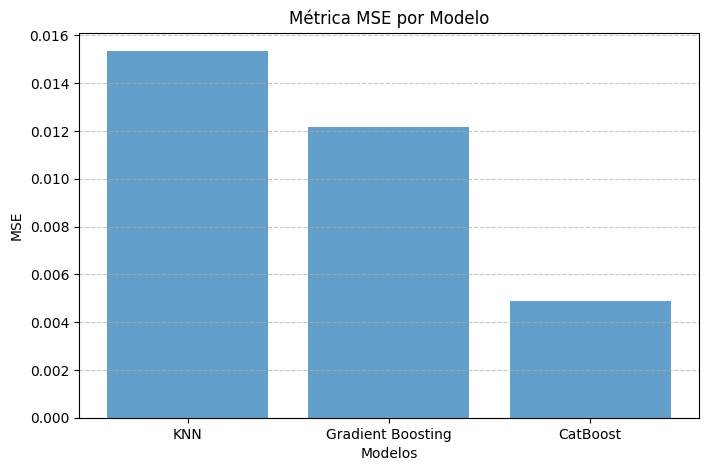

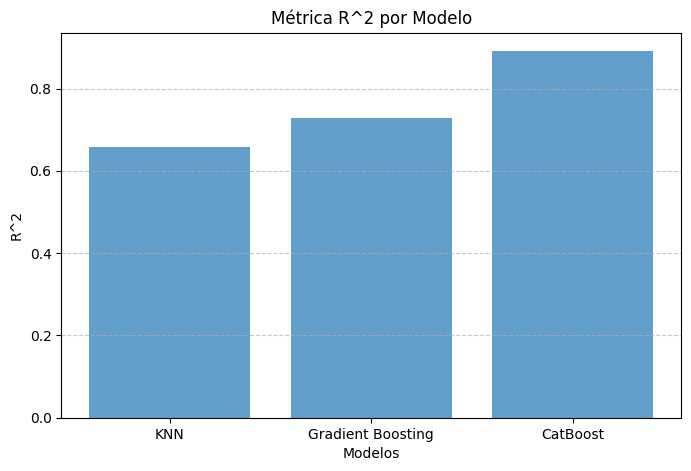

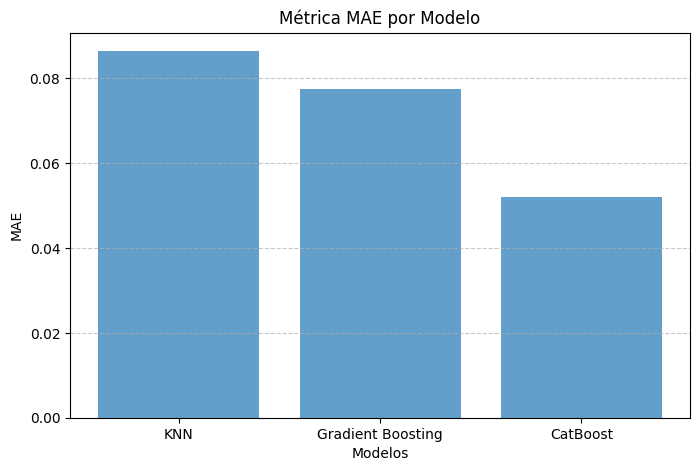

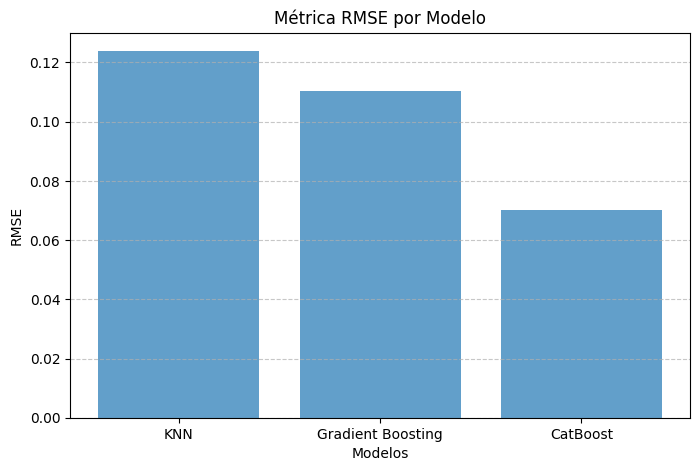

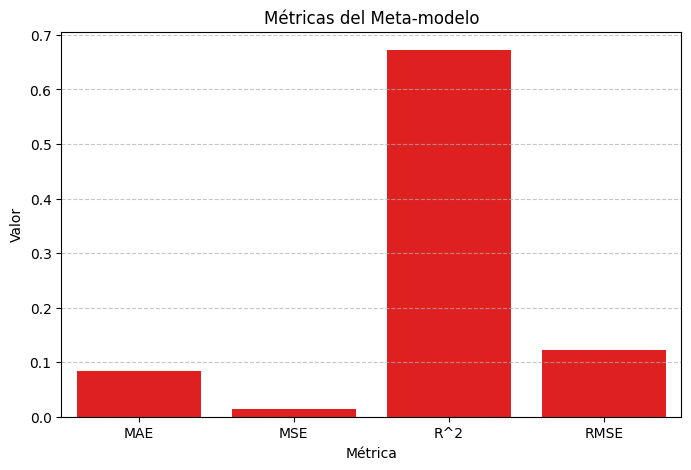


     Actual  Predicted
0      17.0  17.916227
1      18.0  18.351554
2      23.0  22.478986
3      72.0  34.947468
4      38.0  38.530162
..      ...        ...
267    51.0  54.266890
268    60.0  56.146030
269    59.0  58.915401
270    61.0  61.941505
271    66.0  67.111326

[272 rows x 2 columns]



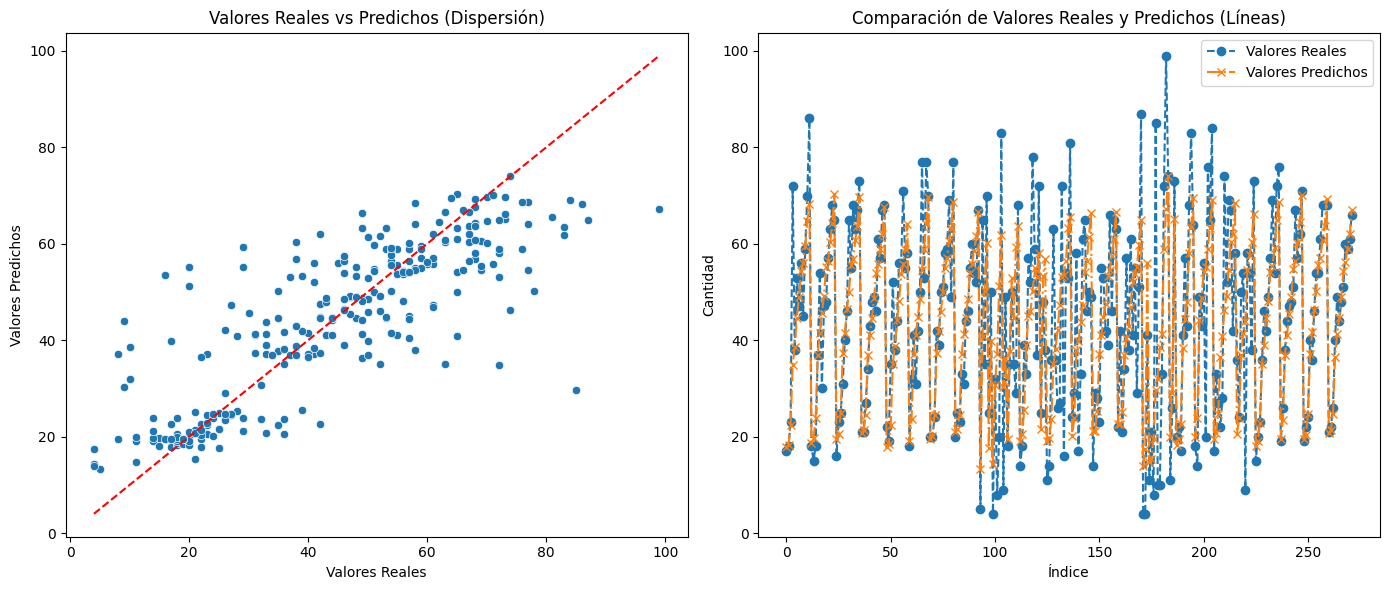

In [ ]:
# 7. EVALUACIÓN DEL MODELO

# Métricas de cada modelo base
base_models = {
    'KNN': stacking_model.named_estimators_['knn'],
    'Gradient Boosting': stacking_model.named_estimators_['gb'],
    'CatBoost': stacking_model.named_estimators_['catboost']
}

# Calcular métricas para cada modelo base
model_metrics = {}
for model_name, model in base_models.items():
    y_pred_base = model.predict(X_test_scaled)
    mse_base = mean_squared_error(y_test, y_pred_base)
    mse_normalizado = mse_base / ((y_test.max() - y_test.min())**2)
    r2_base = r2_score(y_test, y_pred_base)
    mae_base = mean_absolute_error(y_test, y_pred_base)
    mae_normalizado = mae_base / (y_test.max() - y_test.min())
    rmse_base = np.sqrt(mse_base)
    rmse_normalizado = rmse_base / (y_test.max() - y_test.min())

    print(f"Métricas para {model_name}:")
    print(f"  Mean Squared Error (MSE): {mse_normalizado:.4f}")
    print(f"  R^2 Score: {r2_base:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae_normalizado:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse_normalizado:.4f}\n")

    model_metrics[model_name] = {
        'MSE': mse_normalizado,
        'R^2': r2_base,
        'MAE': mae_normalizado,
        'RMSE': rmse_normalizado
    }



# Métricas de evaluación de la salida del Stacking (Salida del Meta-modelo)
meta_mse = mean_squared_error(y_test, y_pred)
meta_r2 = r2_score(y_test, y_pred)
meta_mae = mean_absolute_error(y_test, y_pred)
meta_rmse = np.sqrt(meta_mse)

# Normalizar las métricas de la salida del Stacking
meta_mse_normalizado = meta_mse / ((y_test.max() - y_test.min())**2)
meta_rmse_normalizado = meta_rmse / (y_test.max() - y_test.min())
meta_mae_normalizado = meta_mae / (y_test.max() - y_test.min())
meta_metricas = {'MAE':meta_mae_normalizado, 'MSE':meta_mse_normalizado, 'R^2':meta_r2, 'RMSE':meta_rmse_normalizado}

# Mostrar las métricas del Stacking
print("Métricas del Stacking (Salida del Meta-modelo):")
print(f"  Mean Squared Error (MSE): {meta_mse_normalizado:.4f}")
print(f"  R^2 Score: {meta_r2:.4f}")
print(f"  Root Mean Squared Error (RMSE): {meta_rmse_normalizado:.4f}")
print(f"  Mean Absolute Error (MAE): {meta_mae_normalizado:.4f}\n")

# Gráficas de las métricas de los modelos base
metrics = ['MSE', 'R^2', 'MAE', 'RMSE'] # Fixed indentation here
for metric in metrics:
    values = [model_metrics[model][metric] for model in model_metrics]
    plt.figure(figsize=(8, 5))
    plt.bar(model_metrics.keys(), values, alpha=0.7)
    plt.title(f'Métrica {metric} por Modelo')
    plt.ylabel(metric)
    plt.xlabel('Modelos')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Dataframe para las metricas del Stacking (Salida del meta-modelo)
meta_metricas_df = pd.DataFrame({
    'Métrica': ['MAE', 'MSE', 'R^2', 'RMSE'],
    'Valor': [meta_mae_normalizado, meta_mse_normalizado, meta_r2, meta_rmse_normalizado]
})

meta_metricas_df = pd.DataFrame(list(meta_metricas.items()), columns=['Métrica', 'Valor'])

# Graficar las metricas del Stacking (Salida del meta-modelo)
plt.figure(figsize=(8, 5))
sns.barplot(x='Métrica', y='Valor', data=meta_metricas_df, errorbar=None, color='red')
plt.title('Métricas del Meta-modelo')
plt.ylabel('Valor')
plt.xlabel('Métrica')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Comparar los valores reales vs predichos
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).reset_index(drop=True)
print()
print(comparison)
print()

# Configurar las gráficas
plt.figure(figsize=(14, 6))

# Gráfico de dispersión
plt.subplot(1, 2, 1)
sns.scatterplot(x=comparison['Actual'], y=comparison['Predicted'])
plt.plot([comparison['Actual'].min(), comparison['Actual'].max()],
         [comparison['Actual'].min(), comparison['Actual'].max()],
         color='red', linestyle='--')
plt.title('Valores Reales vs Predichos (Dispersión)')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')

# Gráfico de líneas
plt.subplot(1, 2, 2)
plt.plot(comparison['Actual'].values, label='Valores Reales', marker='o', linestyle='--')
plt.plot(comparison['Predicted'].values, label='Valores Predichos', marker='x', linestyle='-.')
plt.title('Comparación de Valores Reales y Predichos (Líneas)')
plt.xlabel('Índice')
plt.ylabel('Cantidad')
plt.legend()

plt.tight_layout()
plt.show()

Métricas para XGBoost:
  Mean Squared Error (MSE): 0.0005
  R^2 Score: 0.9891
  Mean Absolute Error (MAE): 0.0163
  Root Mean Squared Error (RMSE): 0.0222

Métricas para Random Forest:
  Mean Squared Error (MSE): 0.0033
  R^2 Score: 0.9265
  Mean Absolute Error (MAE): 0.0396
  Root Mean Squared Error (RMSE): 0.0575

Métricas para CatBoost:
  Mean Squared Error (MSE): 0.0049
  R^2 Score: 0.8910
  Mean Absolute Error (MAE): 0.0520
  Root Mean Squared Error (RMSE): 0.0700

Métricas del Stacking (Salida del Meta-modelo):
  Mean Squared Error (MSE): 0.0143
  R^2 Score: 0.6820
  Root Mean Squared Error (RMSE): 0.1196
  Mean Absolute Error (MAE): 0.0849



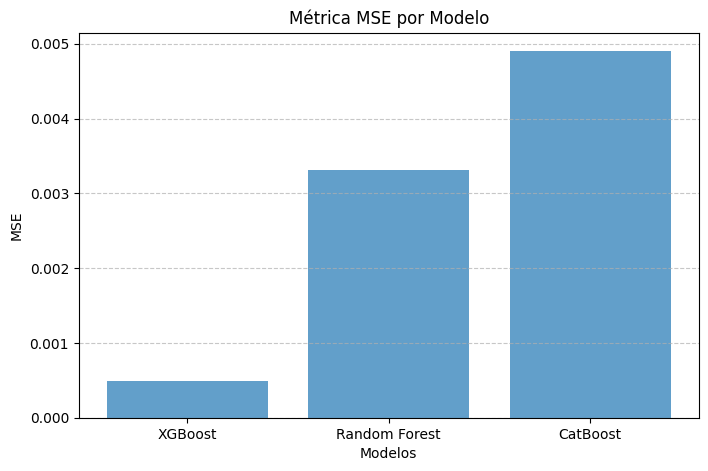

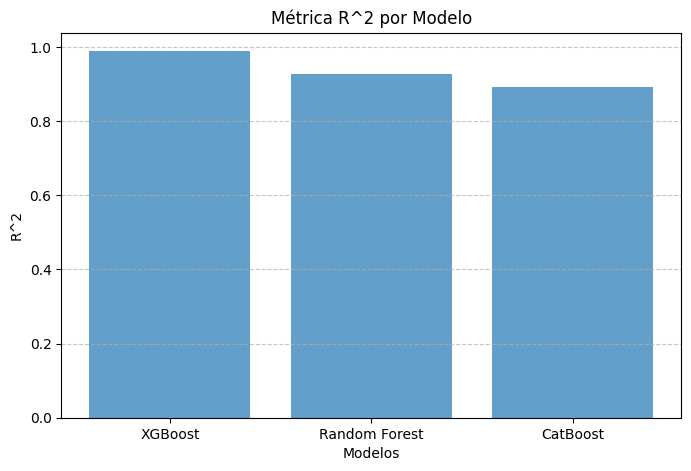

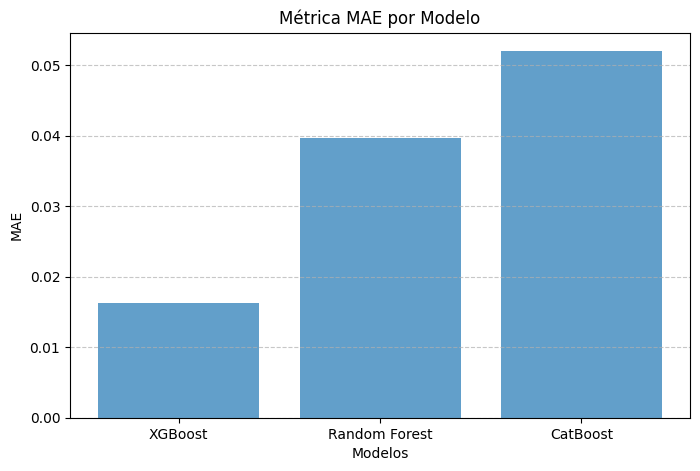

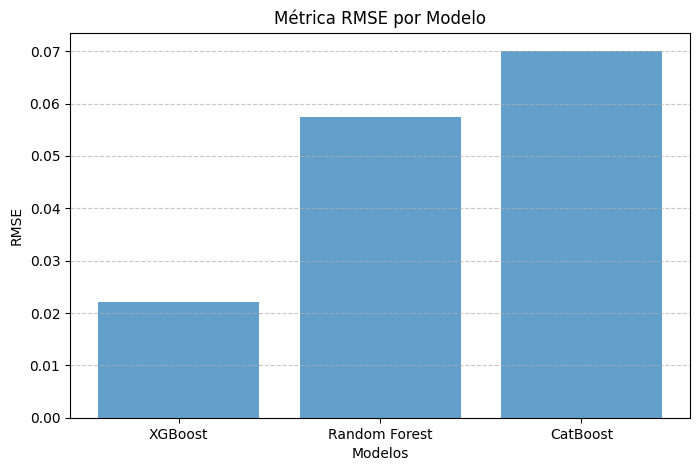

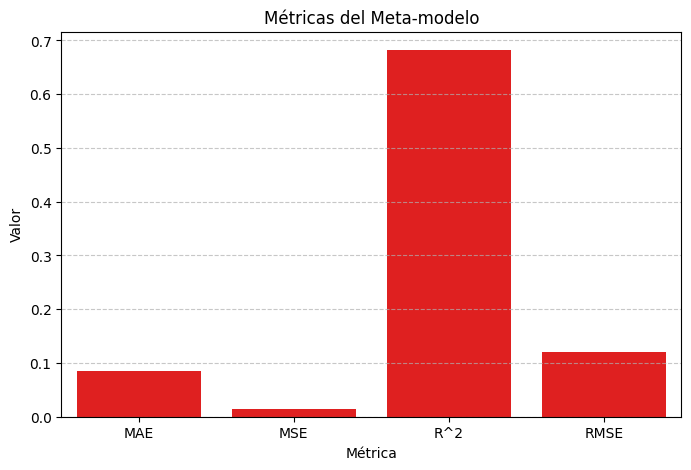


     Actual  Predicted
0      17.0  16.901912
1      18.0  18.681118
2      23.0  24.888932
3      72.0  39.350748
4      38.0  44.560751
..      ...        ...
267    51.0  53.717054
268    60.0  56.859287
269    59.0  56.945282
270    61.0  56.169643
271    66.0  69.525779

[272 rows x 2 columns]



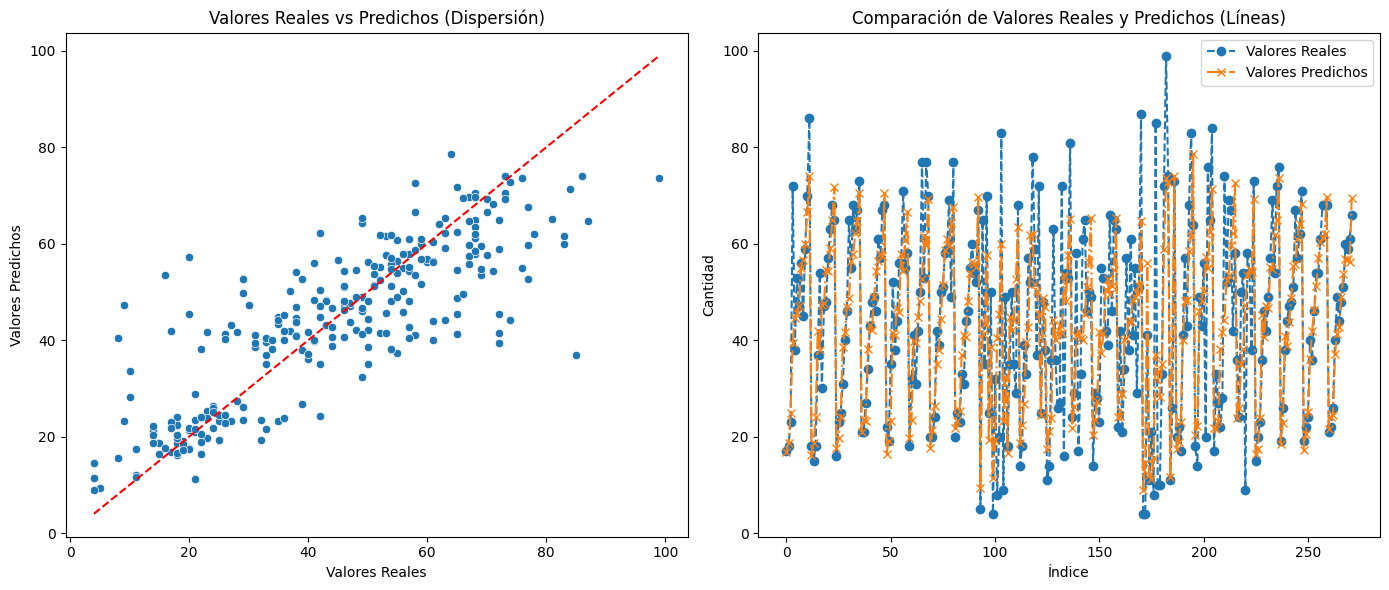

In [ ]:
# 7. EVALUACIÓN DEL MODELO

# Métricas de cada modelo base
base_models = {
    'XGBoost': stacking_model.named_estimators_['xgb'],
    'Random Forest': stacking_model.named_estimators_['rf'],
    'CatBoost': stacking_model.named_estimators_['catboost']
}

# Calcular métricas para cada modelo base
model_metrics = {}
for model_name, model in base_models.items():
    y_pred_base = model.predict(X_test_scaled)
    mse_base = mean_squared_error(y_test, y_pred_base)
    mse_normalizado = mse_base / ((y_test.max() - y_test.min())**2)
    r2_base = r2_score(y_test, y_pred_base)
    mae_base = mean_absolute_error(y_test, y_pred_base)
    mae_normalizado = mae_base / (y_test.max() - y_test.min())
    rmse_base = np.sqrt(mse_base)
    rmse_normalizado = rmse_base / (y_test.max() - y_test.min())

    print(f"Métricas para {model_name}:")
    print(f"  Mean Squared Error (MSE): {mse_normalizado:.4f}")
    print(f"  R^2 Score: {r2_base:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae_normalizado:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse_normalizado:.4f}\n")

    model_metrics[model_name] = {
        'MSE': mse_normalizado,
        'R^2': r2_base,
        'MAE': mae_normalizado,
        'RMSE': rmse_normalizado
    }



# Métricas de evaluación de la salida del Stacking (Salida del Meta-modelo)
meta_mse = mean_squared_error(y_test, y_pred)
meta_r2 = r2_score(y_test, y_pred)
meta_mae = mean_absolute_error(y_test, y_pred)
meta_rmse = np.sqrt(meta_mse)

# Normalizar las métricas de la salida del Stacking
meta_mse_normalizado = meta_mse / ((y_test.max() - y_test.min())**2)
meta_rmse_normalizado = meta_rmse / (y_test.max() - y_test.min())
meta_mae_normalizado = meta_mae / (y_test.max() - y_test.min())
meta_metricas = {'MAE':meta_mae_normalizado, 'MSE':meta_mse_normalizado, 'R^2':meta_r2, 'RMSE':meta_rmse_normalizado}

# Mostrar las métricas del Stacking
print("Métricas del Stacking (Salida del Meta-modelo):")
print(f"  Mean Squared Error (MSE): {meta_mse_normalizado:.4f}")
print(f"  R^2 Score: {meta_r2:.4f}")
print(f"  Root Mean Squared Error (RMSE): {meta_rmse_normalizado:.4f}")
print(f"  Mean Absolute Error (MAE): {meta_mae_normalizado:.4f}\n")

# Gráficas de las métricas de los modelos base
metrics = ['MSE', 'R^2', 'MAE', 'RMSE'] # Fixed indentation here
for metric in metrics:
    values = [model_metrics[model][metric] for model in model_metrics]
    plt.figure(figsize=(8, 5))
    plt.bar(model_metrics.keys(), values, alpha=0.7)
    plt.title(f'Métrica {metric} por Modelo')
    plt.ylabel(metric)
    plt.xlabel('Modelos')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Dataframe para las metricas del Stacking (Salida del meta-modelo)
meta_metricas_df = pd.DataFrame({
    'Métrica': ['MAE', 'MSE', 'R^2', 'RMSE'],
    'Valor': [meta_mae_normalizado, meta_mse_normalizado, meta_r2, meta_rmse_normalizado]
})

meta_metricas_df = pd.DataFrame(list(meta_metricas.items()), columns=['Métrica', 'Valor'])

# Graficar las metricas del Stacking (Salida del meta-modelo)
plt.figure(figsize=(8, 5))
sns.barplot(x='Métrica', y='Valor', data=meta_metricas_df, errorbar=None, color='red')
plt.title('Métricas del Meta-modelo')
plt.ylabel('Valor')
plt.xlabel('Métrica')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Comparar los valores reales vs predichos
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).reset_index(drop=True)
print()
print(comparison)
print()

# Configurar las gráficas
plt.figure(figsize=(14, 6))

# Gráfico de dispersión
plt.subplot(1, 2, 1)
sns.scatterplot(x=comparison['Actual'], y=comparison['Predicted'])
plt.plot([comparison['Actual'].min(), comparison['Actual'].max()],
         [comparison['Actual'].min(), comparison['Actual'].max()],
         color='red', linestyle='--')
plt.title('Valores Reales vs Predichos (Dispersión)')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')

# Gráfico de líneas
plt.subplot(1, 2, 2)
plt.plot(comparison['Actual'].values, label='Valores Reales', marker='o', linestyle='--')
plt.plot(comparison['Predicted'].values, label='Valores Predichos', marker='x', linestyle='-.')
plt.title('Comparación de Valores Reales y Predichos (Líneas)')
plt.xlabel('Índice')
plt.ylabel('Cantidad')
plt.legend()

plt.tight_layout()
plt.show()


# **PREDICCIONES POR CADA AÑO**

     Year  Actual  Predicted      fecha       categoria
12   2017    15.0       14.0 2017-01-01         Biblias
13   2017    17.0       13.0 2017-02-01         Biblias
14   2017    19.0       17.0 2017-03-01         Biblias
15   2017    28.0       26.0 2017-04-01         Biblias
16   2017    31.0       27.0 2017-05-01         Biblias
..    ...     ...        ...        ...             ...
572  2023    51.0       51.0 2023-08-01  Titulos varios
573  2023    60.0       54.0 2023-09-01  Titulos varios
574  2023    59.0       56.0 2023-10-01  Titulos varios
575  2023    61.0       57.0 2023-11-01  Titulos varios
576  2023    66.0       67.0 2023-12-01  Titulos varios

[483 rows x 5 columns]
    Year              categoria  Actual  Predicted
0   2017                Biblias    34.0       33.0
1   2017         Denominacional    33.0       32.0
2   2017               Educases    28.0       28.0
3   2017               Himnario    30.0       28.0
4   2017  Libros de actividades    29.0       28.

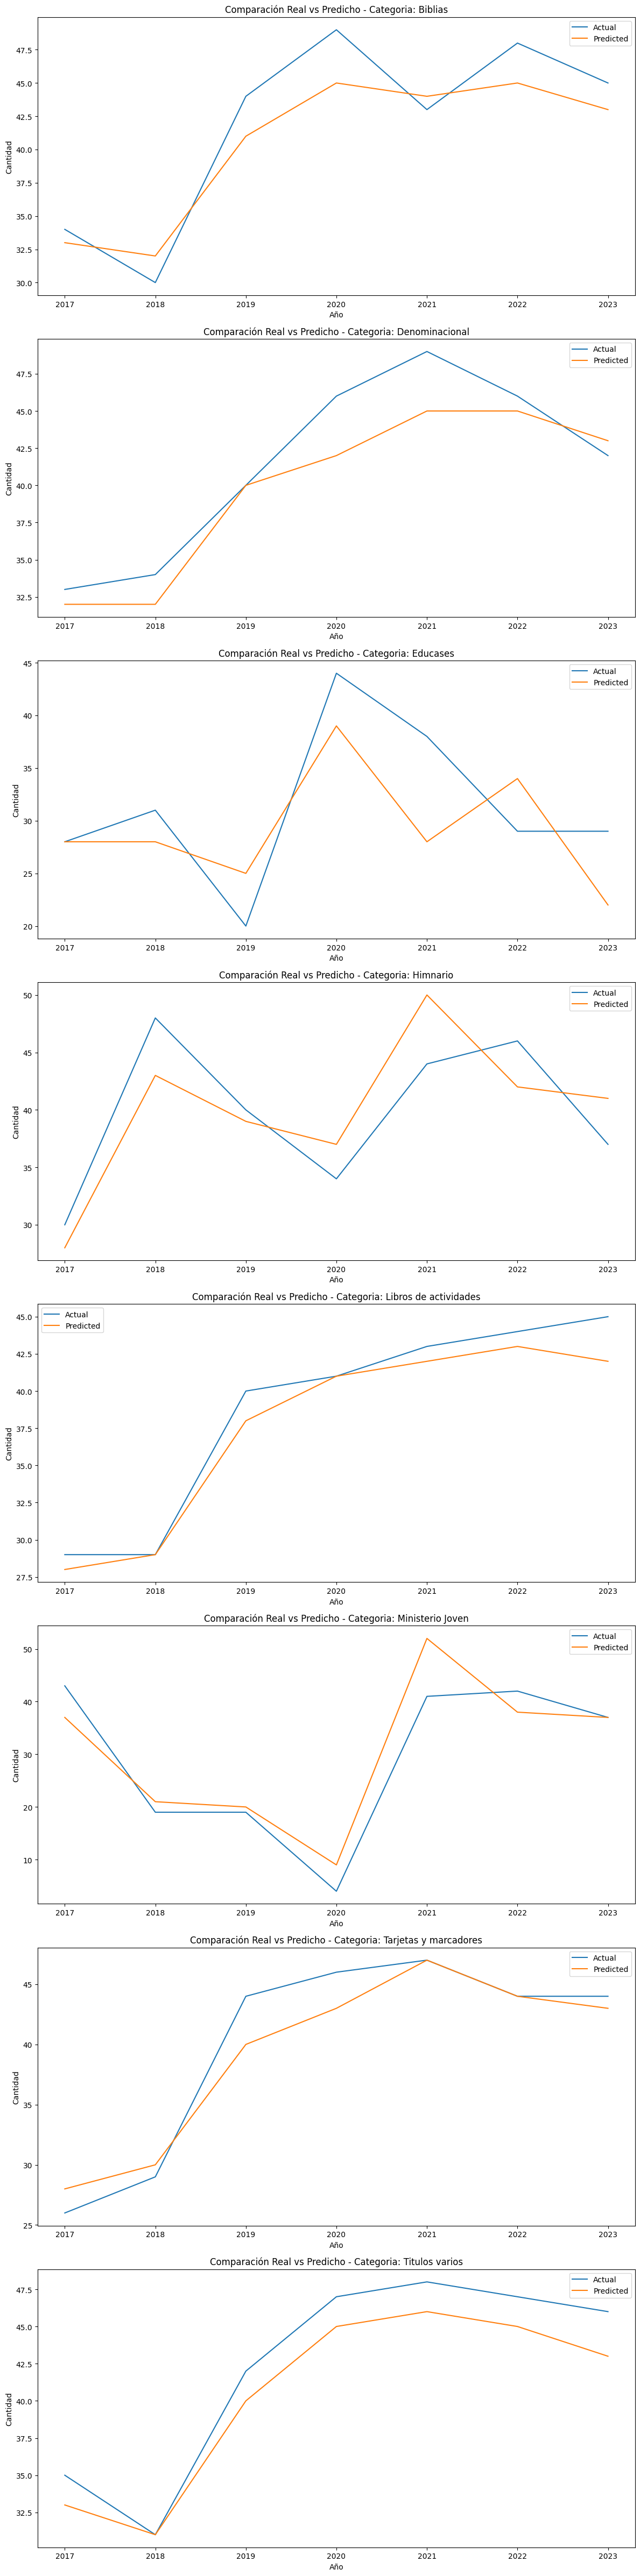

In [ ]:
df_test['cantegoria_Original'] = None

categorias_cols = [col for col in df_test.columns if col.startswith('categoria_')]

for idx, row in df_test.iterrows():
    for col in categorias_cols:
        if row[col] == 1:
            df_test.at[idx, 'categoria_Original'] = col.replace('categoria_', '')
            break

df_promedio_categoria['categoria_Original'] = df_promedio_categoria['categoria']

years = range(2017, 2024)
comparison_results = []

for year in years:
    df_year = df_encoded[df_encoded['Year'] == year]
    X_test = df_year.drop(columns=['cantidad', 'fecha'])
    y_test = df_year['cantidad']

    # Escalar datos de prueba
    X_test_scaled = scaler.transform(X_test)
    y_pred = stacking_model.predict(X_test_scaled)

    # Almacenar resultados
    comparison = pd.DataFrame({
        'Year': [year] * len(y_test),
        'Actual': y_test,
        'Predicted': y_pred
    })
    comparison = pd.merge(comparison, df_promedio_categoria[df_promedio_categoria['fecha'].dt.year == year][['fecha','categoria']], left_index=True, right_index=True, how='left')
    comparison_results.append(comparison)

# Unir todos los resultados
final_comparison = pd.concat(comparison_results).round(0)
print(final_comparison)

final_comparison.to_excel('predicciones_comparacion_distribucion.xlsx', index=False)

# Calcular cantidad promedio real y predicha por año y categoria
avg_comparison = final_comparison.groupby(['Year', 'categoria']).agg({
    'Actual': 'mean',
    'Predicted': 'mean'
}).reset_index().round(0)

print(avg_comparison)

# Graficar comparaciones por año y categoria
categorias = df_promedio_categoria['categoria'].unique()
fig, axes = plt.subplots(nrows=len(categorias), figsize=(12, 6 * len(categorias)))

for i, categoria in enumerate(categorias):
    categoria_data = avg_comparison[avg_comparison['categoria'] == categoria]

    sns.lineplot(data=categoria_data, x='Year', y='Actual', label='Actual', ax=axes[i], errorbar=None)
    sns.lineplot(data=categoria_data, x='Year', y='Predicted', label='Predicted', ax=axes[i], errorbar=None)

    axes[i].set_title(f'Comparación Real vs Predicho - Categoria: {categoria}')
    axes[i].set_xlabel('Año')
    axes[i].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

# **PREDICCIÓN PARA EL AÑO 2024**

        fecha  cantidad_predicha
0  2024-01-01          20.853660
1  2024-02-01          21.345677
2  2024-03-01          24.563130
3  2024-04-01          37.006923
4  2024-05-01          41.178768
..        ...                ...
91 2024-08-01          54.266890
92 2024-09-01          56.146030
93 2024-10-01          58.915401
94 2024-11-01          61.941505
95 2024-12-01          67.111326

[96 rows x 2 columns]


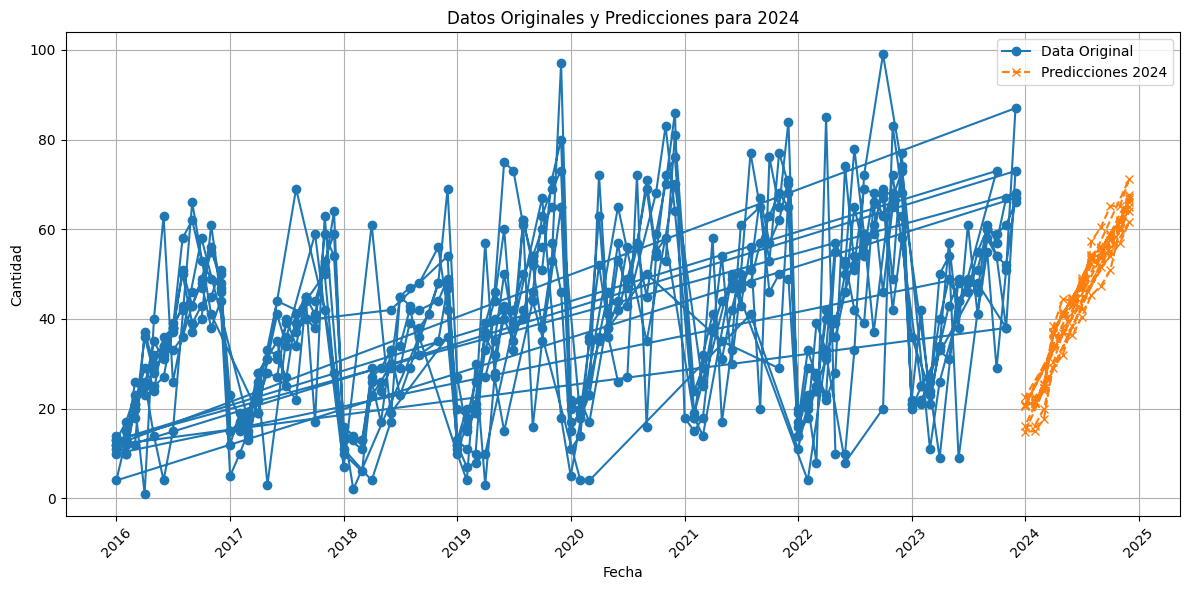

In [ ]:
# Crear datos futuros para el año 2024
unique_categorias = df_promedio_categoria['categoria'].unique()
future_dates = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')

# Crear una lista para almacenar los datos futuros de cada 'categoria'
all_future_data = []

# Iterar a través de cada 'categoria' única para crear datos para 2024
for categoria in unique_categorias:
    future_data = pd.DataFrame({
        'fecha': pd.to_datetime(future_dates),
        'Year': future_dates.year,
        'Month': future_dates.month,
        'categoria': categoria
    })
    all_future_data.append(future_data)

# Concatenar todos los datos futuros en un solo DataFrame
future_data = pd.concat(all_future_data, ignore_index=True)

# Obtener las columnas originales utilizadas durante el entrenamiento
original_columns = X_train.columns

# Crear variables dummy para la columna 'categoria' y alinearlas con las columnas originales
future_data = pd.get_dummies(future_data, columns=['categoria'], prefix=['categoria'], prefix_sep='_')

# Asegurarse de que future_data tenga las mismas columnas que los datos originales
missing_cols = set(original_columns) - set(future_data.columns)
for col in missing_cols:
    future_data[col] = 0  # Agregar las columnas faltantes y rellenarlas con ceros

# Reordenar las columnas para que coincidan con las columnas originales, manteniendo 'fecha'
future_data_reordered = future_data[original_columns] # Seleccionar columnas para el modelo
future_data['cantidad_predicha'] = best_model.predict(scaler.transform(future_data_reordered)) # Predecir usando datos reordenados y transformados
future_results = future_data[['fecha', 'cantidad_predicha']] # Seleccionar columnas del DataFrame futuro que incluyan 'fecha'



# Mostrar las predicciones
print(future_results)

# Concatenar data original con predicciones para graficar
historical_data = df_promedio_categoria[['fecha', 'cantidad']].rename(columns={'cantidad': 'cantidad_real'})
combined_data = pd.concat([
    historical_data,
    future_results.rename(columns={'cantidad_predicha': 'cantidad_real'})
])

# Graficar data original y predicciones
plt.figure(figsize=(12, 6))
plt.plot(historical_data['fecha'], historical_data['cantidad_real'], label='Data Original', marker='o', linestyle='-')
plt.plot(future_results['fecha'], future_results['cantidad_predicha'], label='Predicciones 2024', marker='x', linestyle='--')
plt.title('Datos Originales y Predicciones para 2024')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()